# RD performance of some color transforms

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os

In [2]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

# Notice that the dead-zone to have effect,
# the samples should be allowed to negative.

In [3]:
def load_frame(prefix):
    fn = f"{prefix}.png"
    frame = cv2.imread(fn, cv2.IMREAD_UNCHANGED) # [rows, cols, comp]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(frame)
    frame = frame.astype(np.float32) - 32768.0
    frame = frame.astype(np.int16)
    return frame

def write_frame(frame, prefix):
    frame = frame.astype(np.float32)
    frame += 32768.0
    frame = frame.astype(np.uint16)
    cv2.imwrite(f"{prefix}.png", frame)

In [4]:
def load_indexes(prefix):
    load_frame(prefix)
    
def write_indexes(prefix):
    write_frame(prefix)

In [5]:
fn = "/home/soloelectronicos/MRVC/sequences/stockholm/000"
frame = load_frame(fn)
print(frame.max(), frame.min())

255 0


In [6]:
# Images are normalized to [0,1] before visualize them.
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame(frame, prefix):
    frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame)

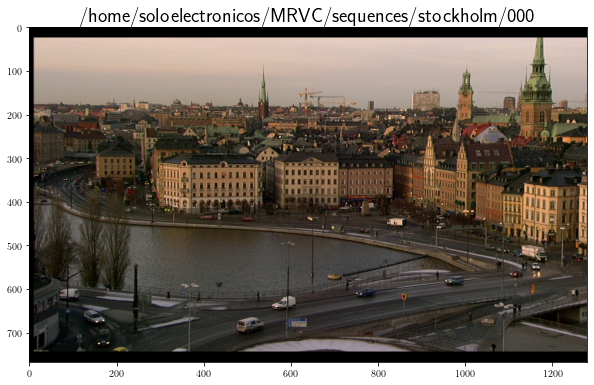

In [7]:
show_frame(frame, fn)

In [8]:
def show_gray_frame(frame, prefix):
    frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame, cmap='gray')

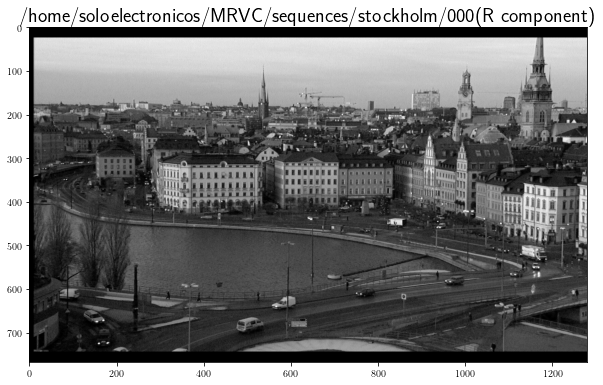

In [9]:
show_gray_frame(frame[:,:,0], fn + "(R component)")

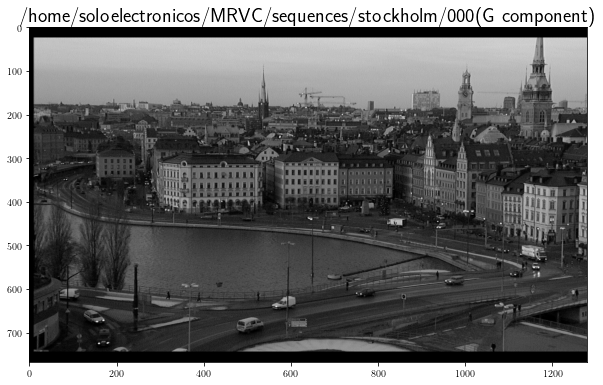

In [10]:
show_gray_frame(frame[:,:,1], fn + "(G component)")

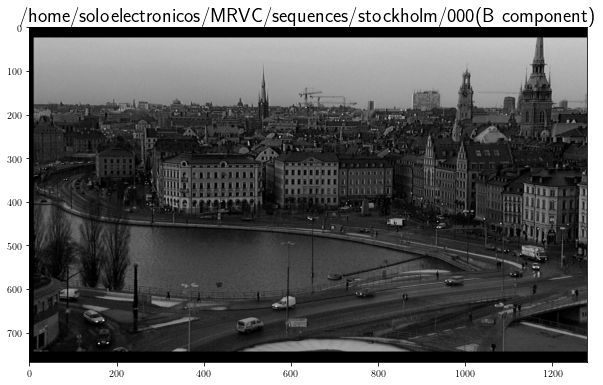

In [11]:
show_gray_frame(frame[:,:,2], fn + "(B component)")

In [12]:
def RGB_to_YCrCb(RGB_frame):
    # Remember that cv2.cvtColor only works with unsigneds!
    YCrCb_frame = cv2.cvtColor(RGB_frame, cv2.COLOR_RGB2YCR_CB)
    return YCrCb_frame

def YCrCb_to_RGB(YCrCb_frame):
    RGB_frame = cv2.cvtColor(YCrCb_frame, cv2.COLOR_YCR_CB2RGB)
    return RGB_frame

def RGB_to_YCoCg(RGB_frame):
    R, G, B = RGB_frame[:,:,0], RGB_frame[:,:,1], RGB_frame[:,:,2]
    YCoCg_frame = np.empty_like(RGB_frame)
    YCoCg_frame[:,:,0] =  R/4 + G/2 + B/4 
    YCoCg_frame[:,:,1] =  R/2       - B/2
    YCoCg_frame[:,:,2] = -R/4 + G/2 - B/4
    return YCoCg_frame

def YCoCg_to_RGB(YCoCg_frame):
    Y, Co, Cg = YCoCg_frame[:,:,0], YCoCg_frame[:,:,1], YCoCg_frame[:,:,2]
    RGB_frame = np.empty_like(YCoCg_frame)
    RGB_frame[:,:,0] = Y + Co - Cg 
    RGB_frame[:,:,1] = Y      + Cg
    RGB_frame[:,:,2] = Y - Co - Cg
    return RGB_frame

### Is the YCrCb reversible?

In [13]:
YCrCb = RGB_to_YCrCb(frame.astype(np.uint8))
frame2 = YCrCb_to_RGB(YCrCb)
assert frame.all() == frame2.all(), "The transform is NOT reversible"
print(frame.max(), frame.min())
print(YCrCb.max(), YCrCb.min(), np.average(YCrCb))

255 0
253 0 112.0066630045573


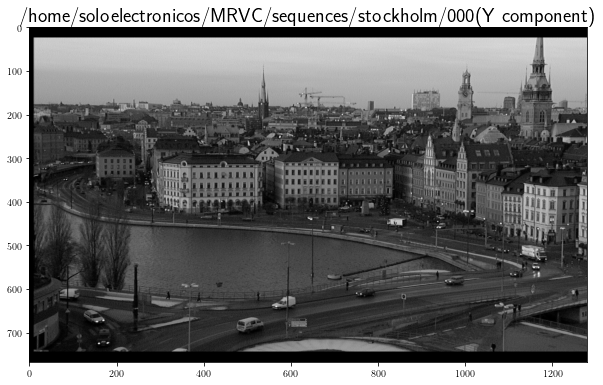

In [14]:
show_gray_frame(YCrCb[:,:,0], fn + "(Y component)")

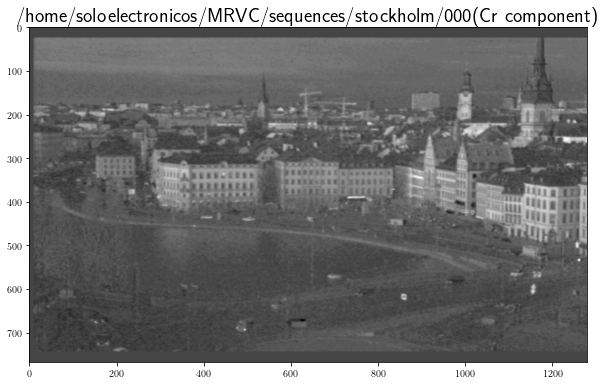

In [15]:
show_gray_frame(YCrCb[:,:,1], fn + "(Cr component)")

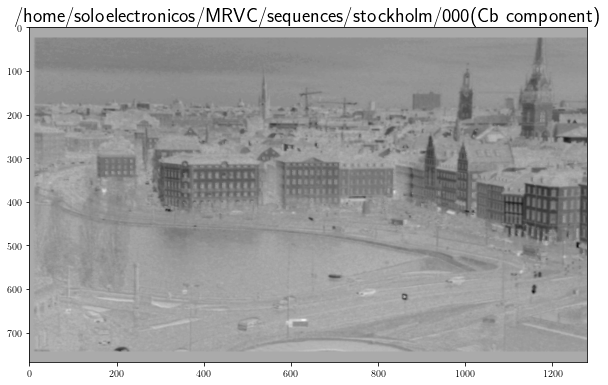

In [16]:
show_gray_frame(YCrCb[:,:,2], fn + "(Cb component)")

### Is the YCoCg reversible?

In [17]:
YCoCg = RGB_to_YCoCg(frame)
frame2 = YCoCg_to_RGB(YCoCg)
assert frame.all() == frame2.all(), "The transform is NOT reversible"
print(frame.max(), frame.min())
print(YCoCg.max(), YCoCg.min(), np.average(YCoCg))

255 0
253 -38 29.832698906792533


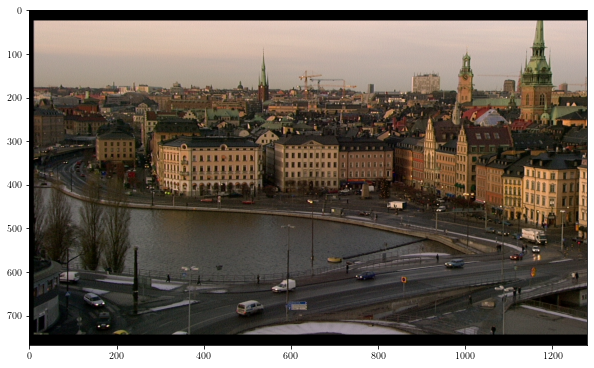

In [18]:
show_frame(frame, "")

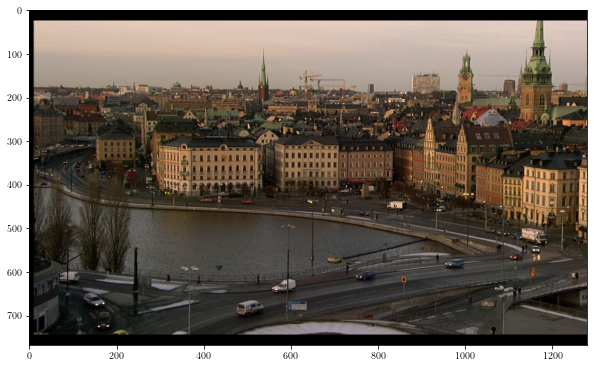

In [19]:
show_frame(frame2, "")

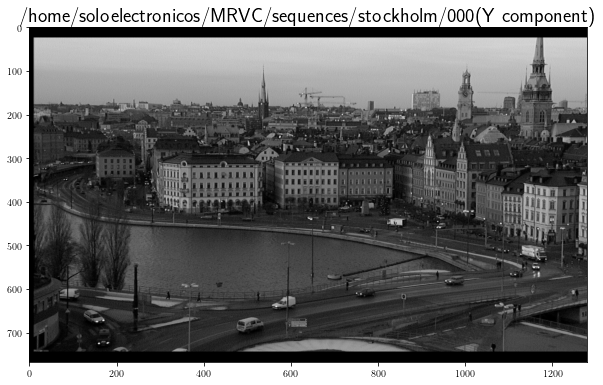

In [20]:
show_gray_frame(YCoCg[:,:,0], fn + "(Y component)")

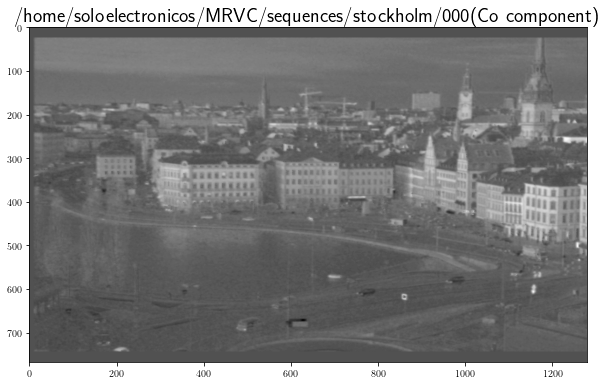

In [21]:
show_gray_frame(YCoCg[:,:,1], fn + "(Co component)")

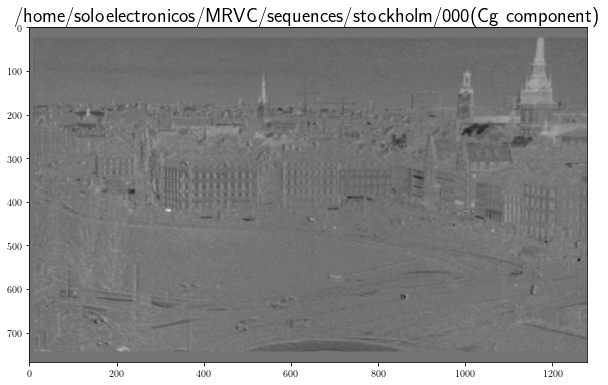

In [22]:
show_gray_frame(YCoCg[:,:,2], fn + "(Cg component)")

## RD stuff

### Rate measurement

In [23]:
def bytes_per_frame(frame):
    write_frame(frame, "/tmp/frame")
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

### Distortion measurement

In [24]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def MSE(x, y):
    error_signal = x - y
    return average_energy(error_signal)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(MSE(error_signal))

## Gains of the YCrCb synthesis filters 

In [25]:
val = 10
delta_YCrCb = np.array([val, 0, 0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Y gain =", average_energy(delta_RGB))

delta_YCrCb = np.array([0, val, 0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Cr gain =", average_energy(delta_RGB))

delta_YCrCb = np.array([0, 0, val]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Cb gain =", average_energy(delta_RGB))

delta_YCrCb = np.array([val, val, val]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB, "Total gain =", average_energy(delta_RGB))

delta_YCrCb = [[[10  0  0]]] delta_RGB = [[[  0 145   0]]] Y gain = 21025.0
delta_YCrCb = [[[ 0 10  0]]] delta_RGB = [[[  0 128   0]]] Cr gain = 16384.0
delta_YCrCb = [[[ 0  0 10]]] delta_RGB = [[[  0 132   0]]] Cb gain = 17424.0
delta_YCrCb = [[[10 10 10]]] delta_RGB = [[[  0 135   0]]] Total gain = 18225.0


As we can see, the energy of the components in the YCrCb domain is not additive (the same must happen with the distortion generated by the quantization).

In [26]:
val = 10
delta_YCoCg = np.array([val, 0, 0]).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Y gain =", average_energy(delta_RGB))

delta_YCoCg = np.array([0, val, 0]).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Cr gain =", average_energy(delta_RGB))

delta_YCoCg = np.array([0, 0, val]).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Cb gain =", average_energy(delta_RGB))

delta_YCoCg = np.array([val, val, val]).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB, "Total gain =", average_energy(delta_RGB))

delta_YCoCg = [[[10  0  0]]] delta_RGB = [[[10 10 10]]] Y gain = 300.0
delta_YCoCg = [[[ 0 10  0]]] delta_RGB = [[[ 10   0 -10]]] Cr gain = 200.0
delta_YCoCg = [[[ 0  0 10]]] delta_RGB = [[[-10  10 -10]]] Cb gain = 300.0
delta_YCoCg = [[[10 10 10]]] delta_RGB = [[[ 10  20 -10]]] Total gain = 600.0


With the YCoCg happens the same (the components are not additive). The gains matches with the theory.

### Energy of the RGB channels

In [27]:
R_energy = average_energy(frame[:,:,0])
G_energy = average_energy(frame[:,:,1])
B_energy = average_energy(frame[:,:,2])
print("Energy of R =", R_energy)
print("Energy of G =", G_energy)
print("Energy of B =", B_energy)

Energy of R = 16031572.591145834
Energy of G = 12341191.74609375
Energy of B = 9893899.2890625


### Energy of the YCrCb channels

In [28]:
YCrCb = RGB_to_YCrCb(frame.astype(np.uint8))
Y_energy = average_energy(YCrCb[:,:,0])
Cr_energy = average_energy(YCrCb[:,:,1])
Cb_energy = average_energy(YCrCb[:,:,2])
print("Energy of Y =", Y_energy)
print("Energy of Cr =", Cr_energy)
print("Energy of Cb =", Cb_energy)

Energy of Y = 13027202.493489584
Energy of Cr = 23271441.41015625
Energy of Cb = 18649035.940104168


### Energy of the YCoCg channels

In [29]:
YCoCg = RGB_to_YCoCg(frame)
Y_energy = average_energy(YCoCg[:,:,0])
Co_energy = average_energy(YCoCg[:,:,1])
Cg_energy = average_energy(YCoCg[:,:,2])
print("Energy of Y =", Y_energy)
print("Energy of Co =", Co_energy)
print("Energy of Cg =", Cg_energy)

Energy of Y = 12413817.684895834
Energy of Co = 307893.3020833333
Energy of Cg = 6258.272135416667


The energy is more concentrated in the YCoCg domain, more specifically in the Y channel.

### Quantization in the RGB domain ($\Delta_{\text{R}} = \Delta_{\text{G}} = \Delta_{\text{B}}$)

In [30]:
def only_Q_RD_curve(x):
    points = []
    for q_step in range(0, 8):
        k, y = q_deq(x, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(x, y)
        points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return points

RGB_points = only_Q_RD_curve(frame)

q_step=  1, rate=2409744 bytes, distortion=   0.0
q_step=  2, rate=2020123 bytes, distortion=1773.4
q_step=  4, rate=1616819 bytes, distortion=12410.9
q_step=  8, rate=1226618 bytes, distortion=61573.7
q_step= 16, rate= 873581 bytes, distortion=272674.1
q_step= 32, rate= 569200 bytes, distortion=1112306.9
q_step= 64, rate= 319281 bytes, distortion=4760206.6
q_step=128, rate=  81184 bytes, distortion=12660496.0


### RD using quantization in the YCbCr domain ($\Delta_{\text{Y}} = \Delta_{\text{Cr}} = \Delta_{\text{Cb}}$)

In [31]:
def YCrCb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        k, dequantized_YCrCb_frame = q_deq(YCrCb_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame.astype(np.uint8))
        distortion = MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

YCrCb_points = YCrCb_RD_curve(frame)

q_step=  1, rate=1596796 bytes, distortion=1242.1
q_step=  2, rate=1330254 bytes, distortion=8222.9
q_step=  4, rate=1065977 bytes, distortion=49492.0
q_step=  8, rate= 791329 bytes, distortion=245342.7
q_step= 16, rate= 527390 bytes, distortion=1050663.0
q_step= 32, rate= 324287 bytes, distortion=3468656.7
q_step= 64, rate= 205689 bytes, distortion=9653170.0
q_step=128, rate=  99929 bytes, distortion=17587368.8


### RD curves of each YCrCb channel

In [32]:
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        Y_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))[:,:,0]
        dequantized_Y_frame = np.empty_like(Y_frame)
        k = np.empty_like(Y_frame)
        k, dequantized_Y_frame = q_deq(Y_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(Y_frame, dequantized_Y_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_Cr_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        Cr_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))[:,:,1]
        dequantized_Cr_frame = np.empty_like(Cr_frame)
        k = np.empty_like(Cr_frame)
        k, dequantized_Cr_frame = q_deq(Cr_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(Cr_frame, dequantized_Cr_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_Cb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        Cb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))[:,:,2]
        dequantized_Cb_frame = np.empty_like(Cb_frame)
        k = np.empty_like(Cb_frame)
        k, dequantized_Cb_frame = q_deq(Cb_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(Cb_frame, dequantized_Cb_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

only_Y_points = only_Y_RD_curve(frame)
only_Cb_points = only_Cb_RD_curve(frame)
only_Cr_points = only_Cr_RD_curve(frame)

q_step=  1, rate= 800943 bytes, distortion=   0.0
q_step=  2, rate= 669382 bytes, distortion= 596.9
q_step=  4, rate= 538458 bytes, distortion=4169.6
q_step=  8, rate= 414155 bytes, distortion=20869.6
q_step= 16, rate= 291281 bytes, distortion=93022.7
q_step= 32, rate= 181101 bytes, distortion=358068.6
q_step= 64, rate= 107084 bytes, distortion=1559420.5
q_step=128, rate=  31327 bytes, distortion=4454852.5
q_step=  1, rate= 296608 bytes, distortion=   0.0
q_step=  2, rate= 211637 bytes, distortion= 549.1
q_step=  4, rate= 142017 bytes, distortion=4328.3
q_step=  8, rate=  89747 bytes, distortion=22364.7
q_step= 16, rate=  49975 bytes, distortion=110433.2
q_step= 32, rate=  32226 bytes, distortion=644724.9
q_step= 64, rate=  28671 bytes, distortion=3382786.1
q_step=128, rate=  28241 bytes, distortion=15616348.3
q_step=  1, rate= 295263 bytes, distortion=   0.0
q_step=  2, rate= 214654 bytes, distortion= 743.2
q_step=  4, rate= 141569 bytes, distortion=4297.6
q_step=  8, rate=  86492 byt

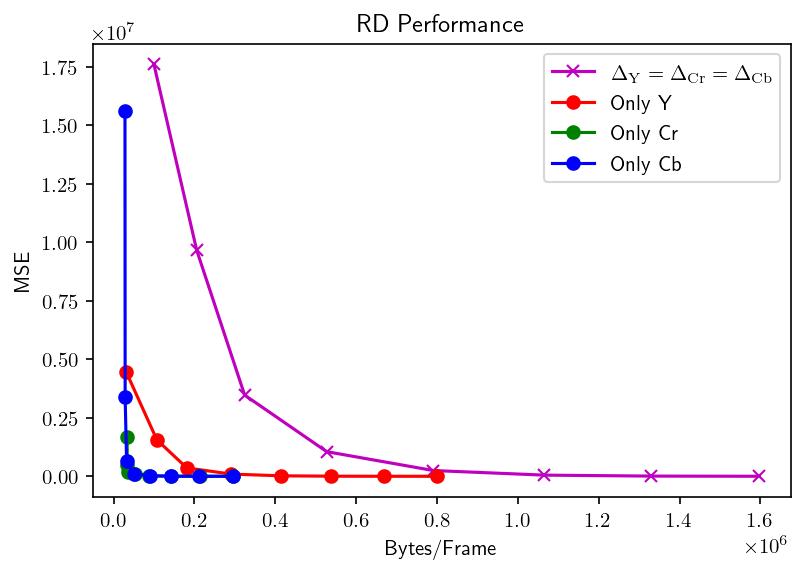

In [33]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCrCb_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Cr}} = \Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='Only Y')              
pylab.plot(*zip(*only_Cr_points), c='g', marker="o",
           label='Only Cr')              
pylab.plot(*zip(*only_Cb_points), c='b', marker="o",
           label='Only Cb')              
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. The distortions are not additive.
2. The slopes of the curves for different quantization steps are different.

### RD using quantization in the YCoCg domain ($\Delta_{\text{Y}} = \Delta_{\text{Co}} = \Delta_{\text{Cg}}$)

In [34]:
def YCoCg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        k, dequantized_YCoCg_frame = q_deq(YCoCg_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

YCoCg_points = YCoCg_RD_curve(frame)

q_step=  1, rate=1635536 bytes, distortion=1842.4
q_step=  2, rate=1335770 bytes, distortion=9164.4
q_step=  4, rate=1035384 bytes, distortion=38091.9
q_step=  8, rate= 748891 bytes, distortion=133917.9
q_step= 16, rate= 489973 bytes, distortion=473211.7
q_step= 32, rate= 283845 bytes, distortion=1540760.0
q_step= 64, rate= 153053 bytes, distortion=5506904.1
q_step=128, rate=  41195 bytes, distortion=13547869.6


### RD curves of each YCoCg channel

In [35]:
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        Y_frame = RGB_to_YCoCg(RGB_frame)[:,:,0]
        dequantized_Y_frame = np.empty_like(Y_frame)
        k = np.empty_like(Y_frame)
        k, dequantized_Y_frame = q_deq(Y_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(Y_frame, dequantized_Y_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_Co_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        Co_frame = RGB_to_YCoCg(RGB_frame)[:,:,1]
        dequantized_Co_frame = np.empty_like(Co_frame)
        k = np.empty_like(Co_frame)
        k, dequantized_Co_frame = q_deq(Co_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(Co_frame, dequantized_Co_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

def only_Cg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        Cg_frame = RGB_to_YCoCg(RGB_frame)[:,:,2]
        dequantized_Cg_frame = np.empty_like(Cg_frame)
        k = np.empty_like(Cg_frame)
        k, dequantized_Cg_frame = q_deq(Cg_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = MSE(Cg_frame, dequantized_Cg_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

only_Y_points = only_Y_RD_curve(frame)
only_Co_points = only_Co_RD_curve(frame)
only_Cg_points = only_Cg_RD_curve(frame)

q_step=  1, rate= 800219 bytes, distortion=   0.0
q_step=  2, rate= 668973 bytes, distortion= 593.9
q_step=  4, rate= 537513 bytes, distortion=4165.3
q_step=  8, rate= 413041 bytes, distortion=20695.0
q_step= 16, rate= 289693 bytes, distortion=91664.5
q_step= 32, rate= 183109 bytes, distortion=362693.1
q_step= 64, rate= 106533 bytes, distortion=1591251.5
q_step=128, rate=  28228 bytes, distortion=4242744.7
q_step=  1, rate= 339400 bytes, distortion=   0.0
q_step=  2, rate= 246297 bytes, distortion= 578.5
q_step=  4, rate= 155453 bytes, distortion=3898.1
q_step=  8, rate=  88744 bytes, distortion=19592.5
q_step= 16, rate=  46353 bytes, distortion=73623.5
q_step= 32, rate=  17878 bytes, distortion=189245.6
q_step= 64, rate=   3884 bytes, distortion=306108.5
q_step=128, rate=   3630 bytes, distortion=307893.3
q_step=  1, rate= 290332 bytes, distortion=   0.0
q_step=  2, rate= 168870 bytes, distortion= 503.3
q_step=  4, rate=  57316 bytes, distortion=2552.2
q_step=  8, rate=  11443 bytes, 

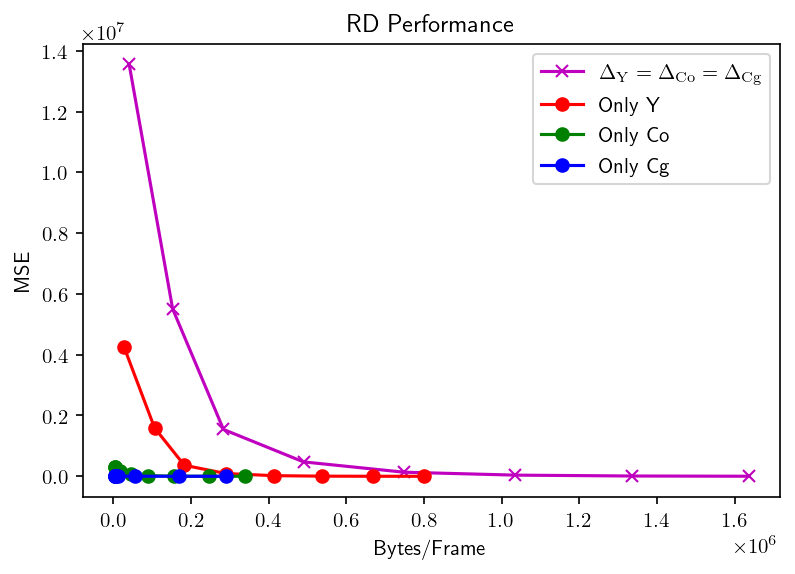

In [36]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCoCg_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Co}} = \Delta_{\mathrm{Cg}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='Only Y')              
pylab.plot(*zip(*only_Co_points), c='g', marker="o",
           label='Only Co')              
pylab.plot(*zip(*only_Cg_points), c='b', marker="o",
           label='Only Cg')              
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. The distortions are not additive.
2. The slopes of the curves for different quantization steps are different.
3. The channel Y should be quantized less.

### RD using channel gains in YCoCg domain

In [37]:
def YCoCg_RD_curve(RGB_frame):
    RD_points = []
    #for q_step in range(0, 8):
    for q_step in range(1, 256):
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        #k, dequantized_YCoCg_frame = q_deq(YCoCg_frame, 1<<q_step)
        k, dequantized_YCoCg_frame = q_deq(YCoCg_frame, q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

YCoCg_points = YCoCg_RD_curve(frame)

relative_Y_gain = 3/2
relative_Co_gain = 1
relative_Cg_gain = 3/2
def YCoCg_RD_curve_with_gains(RGB_frame):
    RD_points = []
    #for q_step in range(0, 8):
    for q_step in range(1, 256):
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame)
        #k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], (1<<q_step)/relative_Y_gain)
        #k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], (1<<q_step)/relative_Co_gain)
        #k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], (1<<q_step)/relative_Cg_gain)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], q_step/relative_Y_gain)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], q_step/relative_Co_gain)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], q_step/relative_Cg_gain)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

YCoCg_gains_points = YCoCg_RD_curve_with_gains(frame)

q_step=  1, rate=1635536 bytes, distortion=1842.4
q_step=  2, rate=1335770 bytes, distortion=9164.4
q_step=  3, rate=1163599 bytes, distortion=21835.9
q_step=  4, rate=1035384 bytes, distortion=38091.9
q_step=  5, rate= 940649 bytes, distortion=57047.0
q_step=  6, rate= 865788 bytes, distortion=78337.6
q_step=  7, rate= 807853 bytes, distortion=99475.0
q_step=  8, rate= 748891 bytes, distortion=133917.9
q_step=  9, rate= 701004 bytes, distortion=162684.0
q_step= 10, rate= 662388 bytes, distortion=193727.5
q_step= 11, rate= 628892 bytes, distortion=231617.1
q_step= 12, rate= 592411 bytes, distortion=270050.8
q_step= 13, rate= 564076 bytes, distortion=312897.6
q_step= 14, rate= 541649 bytes, distortion=354232.0
q_step= 15, rate= 514767 bytes, distortion=422484.1
q_step= 16, rate= 489973 bytes, distortion=473211.7
q_step= 17, rate= 469255 bytes, distortion=529512.2
q_step= 18, rate= 448855 bytes, distortion=586231.0
q_step= 19, rate= 433403 bytes, distortion=646896.9
q_step= 20, rate= 413

q_step=155, rate=  34384 bytes, distortion=15096465.6
q_step=156, rate=  34692 bytes, distortion=15284252.5
q_step=157, rate=  34843 bytes, distortion=15511355.5
q_step=158, rate=  34917 bytes, distortion=15756520.9
q_step=159, rate=  35067 bytes, distortion=15940674.9
q_step=160, rate=  34647 bytes, distortion=16024539.0
q_step=161, rate=  34910 bytes, distortion=16315786.1
q_step=162, rate=  35061 bytes, distortion=16631586.4
q_step=163, rate=  34998 bytes, distortion=16949063.9
q_step=164, rate=  34901 bytes, distortion=17306408.3
q_step=165, rate=  34728 bytes, distortion=17693516.8
q_step=166, rate=  33977 bytes, distortion=17897330.2
q_step=167, rate=  34469 bytes, distortion=18034604.7
q_step=168, rate=  34437 bytes, distortion=18387536.0
q_step=169, rate=  34389 bytes, distortion=18772434.2
q_step=170, rate=  34277 bytes, distortion=19179937.5
q_step=171, rate=  33765 bytes, distortion=19579453.6
q_step=172, rate=  33019 bytes, distortion=19988975.2
q_step=173, rate=  32303 byt

q_step= 54, rate= 251535 bytes, distortion=2106241.4
q_step= 55, rate= 249129 bytes, distortion=2270148.5
q_step= 56, rate= 251807 bytes, distortion=2323914.2
q_step= 57, rate= 252252 bytes, distortion=2280896.7
q_step= 58, rate= 250467 bytes, distortion=2500333.4
q_step= 59, rate= 250772 bytes, distortion=2583601.4
q_step= 60, rate= 245048 bytes, distortion=2585716.1
q_step= 61, rate= 238340 bytes, distortion=2793179.9
q_step= 62, rate= 231282 bytes, distortion=2881754.8
q_step= 63, rate= 224550 bytes, distortion=2817576.9
q_step= 64, rate= 213916 bytes, distortion=3002149.5
q_step= 65, rate= 209208 bytes, distortion=3046241.2
q_step= 66, rate= 206483 bytes, distortion=2959783.7
q_step= 67, rate= 202869 bytes, distortion=3124910.1
q_step= 68, rate= 200407 bytes, distortion=3160829.8
q_step= 69, rate= 198766 bytes, distortion=3104543.5
q_step= 70, rate= 197730 bytes, distortion=3256431.0
q_step= 71, rate= 198488 bytes, distortion=3322702.6
q_step= 72, rate= 198958 bytes, distortion=329

q_step=208, rate=  34054 bytes, distortion=13737889.6
q_step=209, rate=  33629 bytes, distortion=13759198.8
q_step=210, rate=  33629 bytes, distortion=13694535.6
q_step=211, rate=  33480 bytes, distortion=13781918.9
q_step=212, rate=  33193 bytes, distortion=13809241.1
q_step=213, rate=  33193 bytes, distortion=13747762.9
q_step=214, rate=  33250 bytes, distortion=13849946.7
q_step=215, rate=  33160 bytes, distortion=13894301.5
q_step=216, rate=  33160 bytes, distortion=13835972.8
q_step=217, rate=  32992 bytes, distortion=13928773.3
q_step=218, rate=  33102 bytes, distortion=13993998.0
q_step=219, rate=  33102 bytes, distortion=13938782.5
q_step=220, rate=  33465 bytes, distortion=14076931.9
q_step=221, rate=  33978 bytes, distortion=14171074.8
q_step=222, rate=  33978 bytes, distortion=14118924.7
q_step=223, rate=  34357 bytes, distortion=14265777.7
q_step=224, rate=  34766 bytes, distortion=14397170.4
q_step=225, rate=  34766 bytes, distortion=14348030.4
q_step=226, rate=  35253 byt

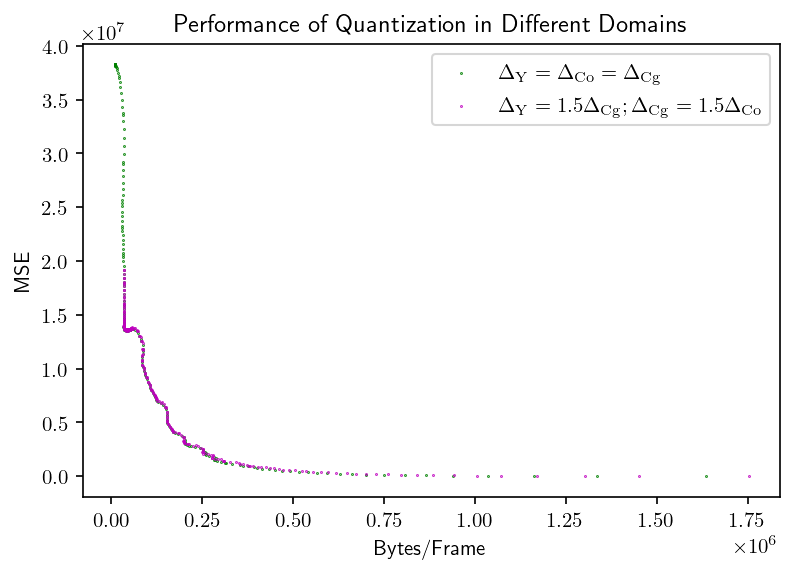

In [38]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*YCoCg_points), c='g', marker=".", s=0.5,
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.scatter(*zip(*YCoCg_gains_points), c='m', marker=".", s=0.5,
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(relative_Y_gain) + '\Delta_{\mathrm{Cg}}' +
           ';\Delta_{\mathrm{Cg}}=' + "{:3.1f}".format(relative_Cg_gain) + '\Delta_{\mathrm{Co}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

### Comparing the three domains using the same quantization steps

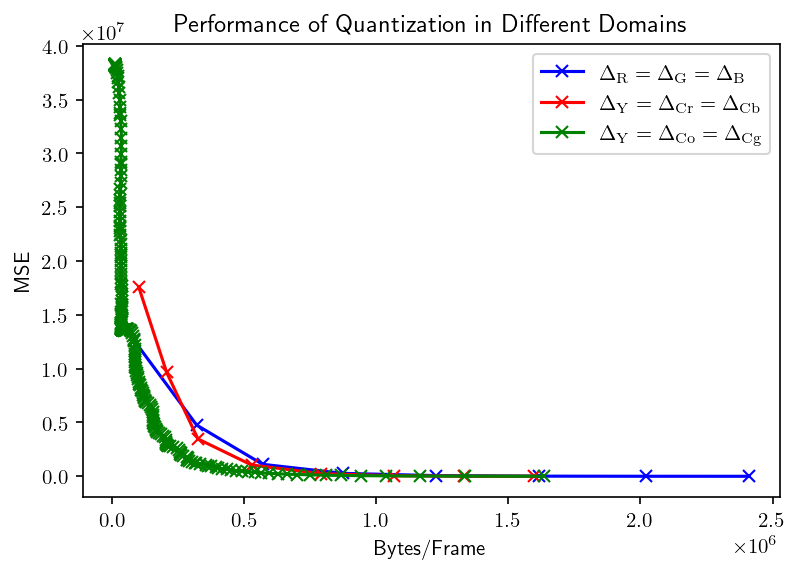

In [39]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), c='b', marker="x",
           label='$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$')
pylab.plot(*zip(*YCrCb_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
#pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
#           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. In general, quantization is more effective in the transformed domain.
3. At low bit-rates, it's better to quantize YCoCb than to quantize YCrCb. 

In [40]:
Cr_gain = 1.0 # 2.4754
Cb_gain = 3.25832/2.4754
Y_gain = 3/2.4754
def YYCrCb_RD_curve_with_gains(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        YYCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YYCrCb_frame = np.empty_like(YYCrCb_frame)
        k = np.empty_like(YYCrCb_frame)
        k[:,:,0], dequantized_YYCrCb_frame[:,:,0] = q_deq(YYCrCb_frame[:,:,0], (1<<q_step)/Y_gain)
        k[:,:,1], dequantized_YYCrCb_frame[:,:,1] = q_deq(YYCrCb_frame[:,:,1], (1<<q_step)/Cr_gain)
        k[:,:,2], dequantized_YYCrCb_frame[:,:,2] = q_deq(YYCrCb_frame[:,:,2], (1<<q_step)/Cb_gain)
        rate = bytes_per_frame(k)
        dequantized_YYCrCb_frame = dequantized_YYCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YYCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
    return RD_points

YYCrCb_gains_points = YYCrCb_RD_curve_with_gains(frame)

TypeError: MSE() missing 1 required positional argument: 'y'

Conclusions:
1. In general, quantization is more effective in the transformed domain considering the RD plane.
2. $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ is slightly better than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$, at low bit-rates, and viceversa.
3. At low bit-rates, tt's better to quantize YCoCb than to quantize YCrCb. 

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ the best quantization in YCrCb?
No, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ is better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at high bit-rates.

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ optimal at low bit-rates quantizing YCrCb?

In [ ]:
N=5
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Cb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Cr_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(frame)
only_Cb_points = only_Cb_RD_curve(frame)
only_Cr_points = only_Cr_RD_curve(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cb_points), c='g', marker="o",
           label='$\Delta_{\mathrm{Cb}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cr_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cr}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

No, there are combinations of $\Delta_{\mathrm{Y}}$, $\Delta_{\mathrm{Cr}}$, and $\Delta_{\mathrm{Cb}}$ better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at low bit-rates.

## Is $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ optimal quantizing YCoCb?

In [ ]:
N=4
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        #k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        #k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Co_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Cg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(frame)
only_Co_points = only_Co_RD_curve(frame)
only_Cg_points = only_Cg_RD_curve(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Co_points), c='m', marker="o",
           label='$\Delta_{\mathrm{Co}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cg_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cg}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

At least, using the same experiment that before, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ seems to be near optimal quantizing YCoCb.

## Ignore the rest ...

## Some experiments showing the impact of the lack of orthogonality

In [ ]:
def _YCbCr_RD_curve(RGB_frame, N):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        dequantized_YCbCr_frame = np.empty_like(YCbCr_frame)
        k = np.empty_like(YCbCr_frame)
        k[:,:,0], dequantized_YCbCr_frame[:,:,0] = q_deq(YCbCr_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCbCr_frame[:,:,1] = q_deq(YCbCr_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCbCr_frame[:,:,2] = q_deq(YCbCr_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

_YCbCr_points_8 = _YCbCr_RD_curve(frame, 8)
_YCbCr_points_7 = _YCbCr_RD_curve(frame, 7)
_YCbCr_points_6 = _YCbCr_RD_curve(frame, 6)
_YCbCr_points_5 = _YCbCr_RD_curve(frame, 5)
_YCbCr_points_4 = _YCbCr_RD_curve(frame, 4)
_YCbCr_points_3 = _YCbCr_RD_curve(frame, 3)

In [ ]:
1<<4

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCbCr_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*_YCbCr_points_8), c='b', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<8))
pylab.plot(*zip(*_YCbCr_points_7), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<7))
pylab.plot(*zip(*_YCbCr_points_6), c='c', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<6))
pylab.plot(*zip(*_YCbCr_points_5), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<5))
pylab.plot(*zip(*_YCbCr_points_4), c='y', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<4))
pylab.plot(*zip(*_YCbCr_points_3), c='k', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<3))
pylab.plot(*zip(*YCbCr_gains_points), c='m', marker="+",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.title("The lack of non-orthogonality in the YCrCb transform")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

From this experiment we conclude that:
1. The luma should not be "deleted" from the code-stream (see curve $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$).
2. There are better combinations than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ and $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

### YCrCb

It's possible to find better combinations than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCbCr(frame.astype(np.uint8))
ycc[:,:,0] = 0
frame2 = YCbCr_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCbCr domain)")

### YCoCg

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCoCg(frame)
ycc[:,:,0]= 0
frame2 = YCoCg_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCoCg domain)")

In [ ]:
def YCbCr_RD_curve_only_Y(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,1] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        k[:,:,0] = 0
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cb(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cr(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,1] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_curve = YCbCr_RD_curve_only_Y(frame)
only_Cb_curve = YCbCr_RD_curve_only_Cb(frame)
only_Cr_curve = YCbCr_RD_curve_only_Cr(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*only_Y_curve), s=2, c='r', marker="o", label='only Y')
pylab.plot(*zip(*only_Y_curve), c='r', marker="o")
pylab.scatter(*zip(*only_Cb_curve), s=2, c='g', marker="o", label='only Cb')
pylab.plot(*zip(*only_Cb_curve), c='g', marker="o")
pylab.scatter(*zip(*only_Cr_curve), s=2, c='b', marker="o", label='only Cr')
pylab.plot(*zip(*only_Cr_curve), c='b', marker="o")
pylab.title("R/D Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
def YCbCr_RD_curve_2(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint16))
        YCbCr_frame[:,:,1] //= 2
        YCbCr_frame[:,:,2] //= 2
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        dequantized_YCbCr_frame[:,:,1] *= 2
        dequantized_YCbCr_frame[:,:,2] *= 2
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint16)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCbCr_quantization_2 = YCbCr_RD_curve_2(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_quantization), s=2, c='b', marker="o", label='RGB quantization')
pylab.plot(*zip(*RGB_quantization), c='b', marker="o")
pylab.scatter(*zip(*YCbCr_quantization), s=2, c='r', marker="o", label='YCbCr quantization')
pylab.plot(*zip(*YCbCr_quantization), c='r', marker="o")
pylab.scatter(*zip(*YCbCr_quantization_2), s=2, c='g', marker="o", label='YCbCr quantization 2')
pylab.plot(*zip(*YCbCr_quantization_2), c='g', marker="o")
pylab.title("R/D Only Quantization")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
YCbCr_test_frame = np.array([255, 0, 0], dtype=np.int16).reshape((1,1,1))
print(YCbCr_to_RGB(YCbCr_test_frame))

In [ ]:
np.array([255, 0, 0], dtype=np.int16)

In [ ]:
YCbCr_test_frame = np.zeros_like(frame).astype(np.uint16)

In [ ]:
type(YCbCr_test_frame[0,0,0])

In [ ]:
YCbCr_test_frame[1,1,2] = 255

In [ ]:
RGB_test_frame = YCbCr_to_RGB(YCbCr_test_frame)

In [ ]:
print(average_energy(RGB_test_frame))

In [ ]:
show_frame(RGB_test_frame, "")